# Analyzing Trends in News Headlines
---

## Introduction
---

* Why I am doing this
    * Feels like I only see negative news, wanted to check if that's so
* Wanted to see if major celebrations effect the amount of negative news
* Wanted to see if there are any patterns in the amount of negative news
    * Time of day
    * Time of the mounth
* Wanted to analyze which country is mentioned the most in the news
* Wanted to analyze which president is mentioned the most in the news

## Collecting Data
---

* Where I am getting the data
* Talk about running a server on DigitalOcean
* Show part of the python `scraper.py` script
* Talk about the identifies, N, J, what they mean
* Talk about the Watson API

### Data Sources

For my sources I decided to use the homepage of [RT](https://www.rt.com/), the politics page of [The Washington Times](http://www.washingtontimes.com/news/politics/), and the politics page of [CBC News](http://www.cbc.ca/news/politics). I choose these three news networks, because they were best known to me.

I made a Python script `scraper.py` to scrape these individual webpages and collect news headlines at different times during the day. The script would scrape all three websites in the morning at around 11:00AM, then during the day at around 14:00PM. and finally in the evening at 18:00PM. 

The reason for having three different news networks and setting the script to scrape at differnt times throughout the day, is because I was trying to get as much variation as possible, to help me find more patterns from the data.

### Automating Work

To save my self the time and headache of remembering to scrape the websites at certain times, I spun a simple Ubuntu droplet on DigitalOcean. I used the [Python Schedule package](https://pypi.python.org/pypi/schedule) to automate the script to run at specific times throughout the day.

To run the script as a background process I used the following command `nohup python3 scraper.py > scraper.out 2>scraper.err &`.


### Watson API

To analyze the news headlines I used IBM's Watson [Natural Language Understanding](https://natural-language-understanding-demo.mybluemix.net/) API. The Natural Language Understanding (NLU) is a collection of differnt APIs that analyze text to help you understand its concepts, entities, keywords, sentiment, and more.

For every news headline I requested the sentiment (provides a score for text either negative, positive, or neutral), emotions (joy, anger, disgust, sadness, and fear), and entities (identifies people, companies, countries, etc.) to be returned by the NLU API.

### Scraper Script

The following is a chunk from the `scraper.py` script, the chunk is used to scraper, analyse, and then write the information (news headlines and their analysis) to a `.txt` file from the RT homepage.

```python
    ...

    with open(filename, mode) as fp:

        # Start of Russia Today news
        fp.write('N RT\n')

        # Scrapes the website of Russia Today news network and writes news headlines to a file
        for ul_tag in soup.find_all('ul', {'class': 'main-promobox__list'}):
            for li_tag in ul_tag.find_all('li', {'class': 'main-promobox__item'}):
                for headline in li_tag.find_all('a', {'class': 'main-promobox__link'}):

                    news_headline = headline.text.lstrip().replace('\n', '')

                    fp.write('H ')
                    fp.write(news_headline)
                    fp.write('\n')
                    fp.write('J ')
                    json.dump(NLU.analyze(text=news_headline, features=[features.Sentiment(), 
                            features.Emotion(), features.Entities()]), fp)
                    fp.write('\n')
    ...
```

## Cleaning Data
---

* Show the txt file, show how the data was initially being stored
* Convert JSON objects into CSV
* Remove irrelavent things from the Entities item, parse for `Trump` amd `Putin`
* Figure something out with morning, day, and evening news
    * Different starting dates
    
### Storing/Saving Data

The following is a chunk from one of the `.txt` files containing information (news headlines and their analysis) from all three news networks. It shows how the information was being stored after every time a website was parsed.

The data shows the first two headlines from RT homepage.

* **N** indicates the start of a new news network.
* **H** indicates a new headline.
* **J** indicates the NLU analysis of the above headline.

```sh

N RT

H ‘Putin wanted Hillary Clinton to win the election’ – Trump                                                                    
J {"language": "en", "entities": [{"relevance": 0.33, "count": 1, "text": "Hillary Clinton", "type": "Person", "disambiguation": {"dbpedia_resource": "http://dbpedia.org/resource/Hillary_Rodham_Clinton", "name": "Hillary Rodham Clinton", "subtype": ["Politician", "Appointee", "AwardWinner", "BoardMember", "Celebrity", "HallOfFameInductee", "OperaCharacter", "Senator", "U.S.Congressperson", "TVActor"]}}, {"relevance": 0.33, "count": 1, "text": "Trump", "type": "Company"}], "sentiment": {"document": {"label": "neutral", "score": 0.0}}, "emotion": {"document": {"emotion": {"anger": 0.179606, "disgust": 0.139299, "sadness": 0.270869, "joy": 0.256665, "fear": 0.082043}}}}

H Berlin to boost aviation safety amid fears hackers can hijack warplanes                                                                    
J {"language": "en", "entities": [{"relevance": 0.33, "count": 1, "text": "Berlin", "type": "Location", "disambiguation": {"subtype": ["City"]}}], "sentiment": {"document": {"label": "neutral", "score": 0.0}}, "emotion": {"document": {"emotion": {"anger": 0.020501, "disgust": 0.034013, "sadness": 0.011869, "joy": 0.021755, "fear": 0.755602}}}}

```

### JSON to CSV

To be able to work with the collected information, I had to convert it into a readable format, such as CSV. The following shows the parsed version of the above chuck from the `.txt` file in an CSV format.

In [36]:
import pandas as pd

# Read data into a DataFrame
sample = pd.read_csv('test.csv')

# Remove the ID column
sample = sample.iloc[:, 1:]

# Show the first 5 rows of the table
sample.head(2)

,DATE,TIME,NETWORK,HEADLINE,SENTIMENT_LABEL,SENTIMENT_SCORE,EMOTION_SADNESS,EMOTION_FEAR,EMOTION_ANGER,EMOTION_DISGUST,EMOTION_JOY,PUTIN,TRUMP,TRUDEAU
0,2017-07-13,11:00:01,RT,‘Putin wanted Hillary Clinton to win the elect...,neutral,0.0,0.270869,0.082043,0.179606,0.139299,0.256665,1,1,0
1,2017-07-13,11:00:01,RT,Berlin to boost aviation safety amid fears hac...,neutral,0.0,0.011869,0.755602,0.020501,0.034013,0.021755,0,0,0


### Missing Values

Sometimes the Watson IBM interpreted the headline as being written in languages other than English, for example French, and the `Emotion` property was missing from the analysis.

```sh

H Montreal nixes sovereignist group's plan to mark Charles de Gaulle's 'Vive le Quebec libre!' speech

J {"warnings": ["emotion: unsupported text language: fr"], "language": "fr", "entities": [{"relevance": 0.978347, "count": 1, "text": "Charles de Gaulle", "type": "Person"}], "sentiment": {"document": {"label": "positive", "score": 0.688072}}}

```

### Country Presidents

The reason I requested the `Entities` property to be returned by the Watson API, is because I wanted to pick the country names and president names from each headline, the API did a good job in doing so, but some times the API would make a mistake. For the following headline the Watson API did not recognize `Putin` to be a president or a person of any type, and it recognized `Trump` to be a company and not a person of type president.

Since, I wanted to avoid these types of errors in the future, I decided to parse the news headline for presidents names instead of the `Entities` property. This worked well, because I was only interested in three presidents/prime ministers `Trump`, `Trudeau`, and `Putin`.

```sh

H ‘Putin wanted Hillary Clinton to win the election’ – Trump                                                                    
J {"language": "en", "entities": [{"relevance": 0.33, "count": 1, "text": "Hillary Clinton", "type": "Person", "disambiguation": {"dbpedia_resource": "http://dbpedia.org/resource/Hillary_Rodham_Clinton", "name": "Hillary Rodham Clinton", "subtype": ["Politician", "Appointee", "AwardWinner", "BoardMember", "Celebrity", "HallOfFameInductee", "OperaCharacter", "Senator", "U.S.Congressperson", "TVActor"]}}, {"relevance": 0.33, "count": 1, "text": "Trump", "type": "Company"}], "sentiment": {"document": {"label": "neutral", "score": 0.0}}, "emotion": {"document": {"emotion": {"anger": 0.179606, "disgust": 0.139299, "sadness": 0.270869, "joy": 0.256665, "fear": 0.082043}}}}

```

## Analyzing Data
---

* Compare Negative and Positive news
    * How many Negative and Positive news in total - Pie Chart
    * How does time of day effect the number of Negative and Positive news - Line Chart with specific time internval
    * How does big celebrations (Stampede) effected the number of Negative News, did they increase or decrease over the course of that week - Line Chart only showing CBC news
* Compare the Emoitions (Joy, Anger, Saddness, etc...)
    * See which emotion doninates - Bubble Chart with bubbles being the emojis corresponding to the feeling
    * Talk about why the dominant emotion doninates
        * Talk about the Article (link in GDrive)
* Draw a Line Chart with all the news, one chart for all networks in the morning, day, and evening
    * Trying to see patterns, if they repeat the number of negatives news every week
    * See if there are more negative news in the morning, day, or evening

In [65]:
sample.head()

,DATE,TIME,NETWORK,HEADLINE,SENTIMENT_LABEL,SENTIMENT_SCORE,EMOTION_SADNESS,EMOTION_FEAR,EMOTION_ANGER,EMOTION_DISGUST,EMOTION_JOY,PUTIN,TRUMP,TRUDEAU
0,2017-07-13,11:00:01,RT,‘Putin wanted Hillary Clinton to win the elect...,neutral,0.000000,0.270869,0.082043,0.179606,0.139299,0.256665,1,1,0
1,2017-07-13,11:00:01,RT,Berlin to boost aviation safety amid fears hac...,neutral,0.000000,0.011869,0.755602,0.020501,0.034013,0.021755,0,0,0
2,2017-07-13,11:00:01,RT,‘Humanity can’t continue to lose out to politi...,negative,-0.962583,0.613501,0.071162,0.218139,0.293269,0.010185,0,0,0
3,2017-07-13,11:00:01,RT,US senators aim to impose sanctions on financi...,negative,-0.573193,0.112259,0.146528,0.091876,0.118333,0.084398,0,0,0
4,2017-07-13,11:00:01,RT,Emails to Trump Jr. on Russian lawyer meeting ...,positive,0.439946,0.121639,0.339342,0.184405,0.068986,0.089517,0,0,0


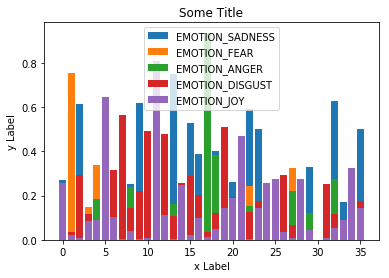

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

# Read data into a DataFrame
sample = pd.read_csv('test.csv')

# Remove the ID column
sample = sample.iloc[:, 1:]

x = [x for x in range(len(sample))]
y1 = sample['EMOTION_SADNESS']
y2 = sample['EMOTION_FEAR']
y3 = sample['EMOTION_ANGER']
y4 = sample['EMOTION_DISGUST']
y5 = sample['EMOTION_JOY']

plt.bar(x, y1, label='EMOTION_SADNESS')
plt.bar(x, y2, label='EMOTION_FEAR')
plt.bar(x, y3, label='EMOTION_ANGER')
plt.bar(x, y4, label='EMOTION_DISGUST')
plt.bar(x, y5, label='EMOTION_JOY')

plt.legend()

plt.title('Some Title')
plt.xlabel('x Label')
plt.ylabel('y Label')
plt.show()

neutral     18
negative    11
positive     7
Name: SENTIMENT_LABEL, dtype: int64


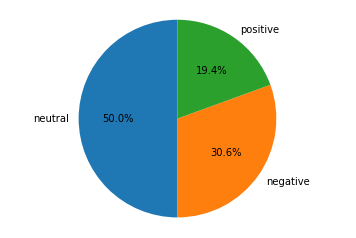

In [55]:
count = sample['SENTIMENT_LABEL'].value_counts()

labels = 'neutral', 'negative', 'positive'
sizes = [count[0], count[1], count[2]]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, 
        labels = labels, 
        autopct = '%1.1f%%', 
        startangle = 90)

ax1.axis('equal')

plt.show()

## Represent Data
---

* Who is the most mentioned president
    * Trump, Putin, Trudeau - Pie Chart
* Which country is the most mentioned
    * Russia, America, Canada, etc.

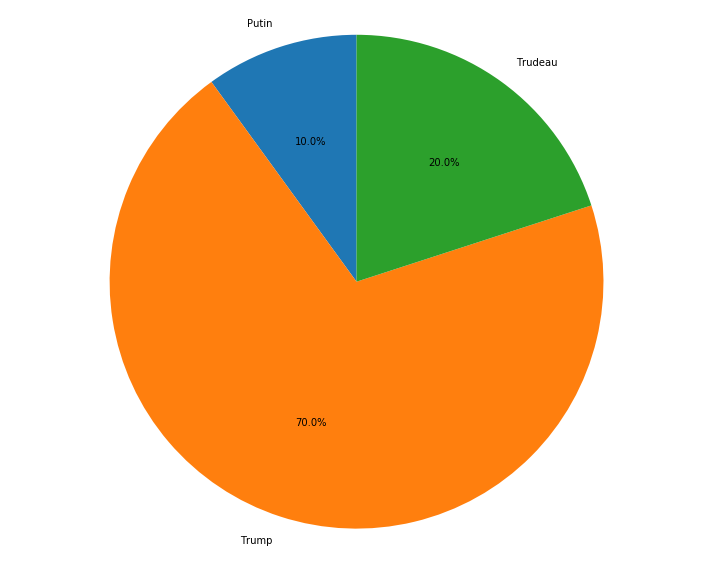

In [66]:
putin_count = sample['PUTIN'].value_counts()
trump_count = sample['TRUMP'].value_counts()
trudeau_count = sample['TRUDEAU'].value_counts()

labels = 'Putin', 'Trump', 'Trudeau'
sizes = [putin_count[1], trump_count[1], trudeau_count[1]]

fig1, ax1 = plt.subplots(figsize = (10, 8))
ax1.pie(sizes, 
        labels = labels, 
        autopct = '%1.1f%%', 
        startangle = 90)

ax1.axis('equal')

plt.tight_layout()
plt.show()

0.145578657143


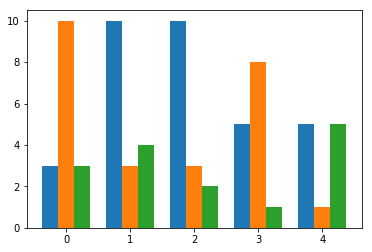

In [111]:
data = ((3, 10, 3), (10, 3, 4), (10, 3, 2), (5, 8, 1), (5, 1, 5))

# Number of items in each tuple
number_of_items = len(data[0])

# Width of each bar
w = 0.75

# Divide the width by number of items in each tuples
bar_width = w / number_of_items

# Create the list for x-axis
x = np.arange(len(data))

for i in range(len(data[0])):
    
    # List of tuple elements
    y = [d[i] for d in data]
    
    # plt.bar(x, y, width of the bars)
    plt.bar(x + (i * bar_width), y, bar_width)

# Places the x-axis ticks in the middle of two bars
# map(str, x) maps x to type string
plt.xticks(x + bar_width, map(str, x))

plt.show()

0.280625457143 0.1327524 0.165762285714 0.1910632 0.145578657143


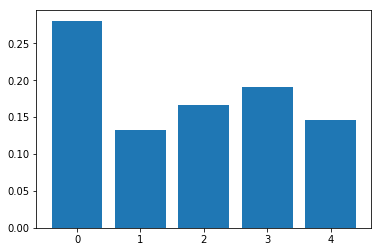

In [130]:
sadness_mean = sample['EMOTION_SADNESS'].mean()
fear_mean = sample['EMOTION_FEAR'].mean()
anger_mean = sample['EMOTION_ANGER'].mean()
disgust_mean = sample['EMOTION_DISGUST'].mean()
joy_mean = sample['EMOTION_JOY'].mean()

data = ((sadness_mean, fear_mean, anger_mean, disgust_mean, joy_mean))
print(sadness_mean, fear_mean, anger_mean, disgust_mean, joy_mean)

# Number of items in each tuple
number_of_items = len(data)

# Width of each bar
w = 0.75

# Divide the width by number of items in each tuples
bar_width = w / number_of_items

# Create the list for x-axis
x = np.arange(len(data))
y = [d for d in data]

# plt.bar(x, y, width of the bars)
plt.bar(x, y)

# # Places the x-axis ticks in the middle of two bars
# # map(str, x) maps x to type string
# plt.xticks(x + bar_width, map(str, x))

plt.show()